# Notebook dedicated to solve and compute the cross-section of ES of solar Nu_e with electrons

The ideia is to compute the cross-section from the interaction solving the differential equation of dσ/dT, where T = E - m is the kinetic energy of the recoil electron electron in the ES interaction $\nu_e + e^- \rightarrow{} e^- + \nu_e$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spence
import scipy.integrate as integrate

# Definitions

- Differential Cross Section:

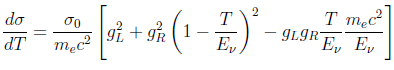

This cross-section can be computed analytically. 

- Differential Cross Section with radiative corrections (Only relevant for 8B and hep neutrinos!):

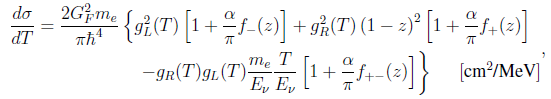

This cross section will need a numerical integration

## Electron Recoil Energy Formulas

Max Energy

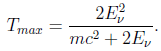

Min Energy (must be integrated over theta from 0 to 2pi

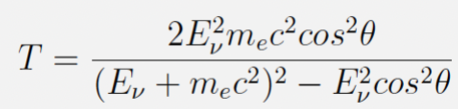

## Function for the minimun kinetic energy of the electron

In [82]:
def Tmin_func(theta, E_nu):
    
    '''
    Function to compute the minimum kinetic energy of the 
    recoil electron. This function mus be integrated with
    respect to theta in the interval [0, 2pi].
    
    Parameters:
    - theta: Angle of scattering
    - E_nu: energy of the incident neutrino in MeV
    
    return: Value of energy
    '''
    
    m_e = 0.5109989461 # Electron mass in MeV/c^2
    
    num = 2*(E_nu**2)*m_e*(np.cos(theta))**2
    den = (E_nu + m_e)**2 - (E_nu**2)*(np.cos(theta))**2
    
    T = (num/den) * (1 / (2*np.pi))
    
    return T

# Cross Section function (Analytical Solution)

In [83]:
def cross_sec_ES_nu_e(E_nu):
    
    """
    Compute the cross-section of neutrino-electron ES without radiative 
    corrections by analytically integrating dσ/dT between Tmin and Tmax(E).

    Parameters:
    -E_nu: scalar or array of neutrino energies (MeV)

    returns: sigma(E) in same units as sigma0_over_me_c2 * MeV
    """

    E_nu = np.asarray(E_nu, dtype=float)

    # -------- constants --------
    m_e = 0.5109989461            # electron mass energy in MeV/c^2 
    c = 3 * 10 ** (10)            # speed of light cm/s
    sigma_0 = 8.81 * 10**(-45)    # cm^2
    g_R = 0.23116                 # sin^2(Weinberg angle)
    g_plus_L = g_R + 1/2          # Plus for electron neutrino ES
    g_minus_L = g_R - 1/2         # minus for (muon,tau) neutrino ES
    
    
    # Recoil Electron Energy values:
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu) # Maximum Kinetic energy of recoil electron
    Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0] # Minimum kinetic energy of recoil electron (Integration over theta)

    # -------- Cross-section Computation --------

    # coefficients from algebra of the cross-section
    C0 = (g_plus_L**2 + g_R**2)
    A1 = (-2.0 * g_R**2 / E_nu) - (g_plus_L * g_R * m_e / (E_nu**2 + 1e-300))  # avoid div by 0
    A2 = g_R**2 / (E_nu**2 + 1e-300)

    # compute differences of integration
    dT = Tmax - Tmin
    dT2 = (Tmax**2 - Tmin**2)
    dT3 = (Tmax**3 - Tmin**3)

    integral = C0 * dT + 0.5 * A1 * dT2 + (1.0/3.0) * A2 * dT3
    
    # Final result
    sigma = (sigma_0/m_e) * integral
    
    return sigma


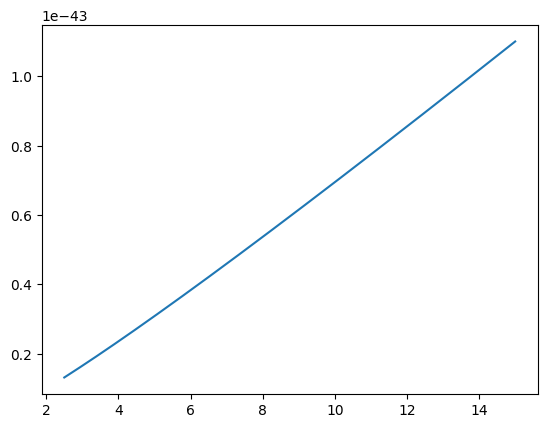

In [84]:
E_nu = np.linspace(2.5, 15, 200)
cross_sec = []

#plt.figure(figsize = (8,6))
for E_nu_i in E_nu:
    cross_sec.append(cross_sec_ES_nu_e(E_nu_i))
    
plt.plot(E_nu, cross_sec)
plt.show()

# Cross Section Function with Radiative Corrections

We must write the differential cross section equation with radiative corrections and then solve it numerically

In [85]:
def dSigma_dT_corr(T, E_nu):
    
    '''
    Function that defines the differential cross section equation
    as a function of the recoil electron energy with QED radiative
    corrections.
    
    Parameters:
    -E_nu: scalar of neutrino energies (MeV)  
    
    return: The value of the differential equation at each point
    
    NOTE: The Spence function function in scipy is different than 
          the convention in arXiv:astro-ph/9502003, so L(x) must be 
          written as L(1-x)
    '''
    
    E_nu = np.asarray(E_nu, dtype=float)
    
    # ---------- Constants ----------
    pi = np.pi
    G_F = 1.16639 * 10 **(-11)               # Fermi Constant MeV^(-2)
    h_bar = (4.135668 * 10**(-21))/(2*pi)   # Plank bar constant in MeV.s
    c = 3 * 10 ** (10)            # speed of light cm/s
    m_e = 0.5109989461                      # electron mass energy in MeV/c^2 
    alpha = 1/137                           # Fine structure constant
    sin_theta_w = 0.23116                   # sin^2(Weinberg angle)

    hbar_c = h_bar * c
    
    # ---------- Recoil Electron Energy values ----------
    
    #Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu)                    # Maximum Kinetic energy of recoil electron
    #Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0] # Minimum kinetic energy of recoil electron (Integration over theta)
    #T = np.linspace(Tmin, Tmax, 200)
    
    # -------- g_L(T) and g_R(T) functions for nu_e --------
    
    rho_NC = 1.0126
    x = np.sqrt(1 + 2*m_e/T)
    I = (1/6) * (1/3 + (3 - x**2) * (0.5 * x * np.log((x + 1)/(x - 1)) - 1))
    k = 0.9791 + 0.0097*I  # !! DUDA: La expresion tiene +/- 0.0025, cual debo usar?? O es una incerteza asociada?
    
    g_L = rho_NC * (0.5 - k * sin_theta_w) - 1
    g_R = -rho_NC * k * sin_theta_w
    
    
    # -------- QED functions f+, f-, f+/- --------
    
    z = T / (E_nu + 1e-300)
    E_e = T + m_e                 #Electron energy = kinetic energy + rest mass energy
    p_e = np.sqrt(E_e**2 - m_e**2)  # Electron 3-momentum modulo
    beta = p_e / E_e
    
    epsilon = 1e-100  #Logaritmic regularizer
    
    # f-
    term1_minus = ((E_e/p_e)*np.log((E_e + p_e)/m_e) - 1)*(2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon)) - np.log(np.maximum(1 - z, epsilon)) - 0.5*np.log(np.maximum(z, epsilon)) - (5/12))
    term2_minus = 0.5*(spence(1 - z) - spence(1 - beta)) - 0.5 * (np.log(np.maximum(1 - z, epsilon)))**(2) - (11/12 + z/2) * np.log(np.maximum(1 - z, epsilon))
    term3_minus = z * (np.log(np.maximum(z, epsilon)) + 0.5*np.log(2*E_nu/m_e)) - (31/18 + (1/12)*np.log(np.maximum(z, epsilon)))*beta - (11/12)*z + (z**2)/24
    
    f_minus = term1_minus + term2_minus + term3_minus
    
    # (1-z)^2 * f+
    term1_plus = ((E_e/p_e)*np.log((E_e + p_e)/m_e) - 1)*(((1 - z)**2) * (2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon)) - np.log(np.maximum(1 - z, epsilon)) - 0.5*np.log(np.maximum(z, epsilon)) - 2/3) - 0.5*((z**2)*np.log(np.maximum(z, epsilon)) + 1 - z))
    term2_plus = -(0.5*(1 - z)**2)*((np.log(np.maximum(1 - z, epsilon)))**2 + beta * (spence(z) - np.log(np.maximum(z, epsilon))*np.log(np.maximum(1 - z, epsilon))))
    term3_plus = np.log(np.maximum(1 - z, epsilon))*(0.5*(z**2) * np.log(np.maximum(z, epsilon)) + ((1 - z)/3) * (2*z - 0.5))
    term4_plus = -0.5*(z**2)*spence(z) - (z*(1 - 2*z)/3) * np.log(np.maximum(z, epsilon)) - z*(1-z)/6
    term5_plus = -(beta/12) * (np.log(np.maximum(z, epsilon)) + (1 - z)*((115 - 109*z)/6))
    
    f_plus_prod = term1_plus + term2_plus + term3_plus + term4_plus + term5_plus
    f_plus = f_plus_prod / ((1-z)**2)
    
    # f+/-
    f_pm = ((E_e/p_e)*np.log((E_e + p_e) / m_e) - 1) * 2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon))
    
    # ------ Differential Cross Section Calculation in cm^2 / MeV ------
    
    #factor = 2 * (G_F**2) * m_e / (pi * h_bar**4)
    factor = 2 * (G_F**2) * m_e / pi
    term1 = (g_L**2) * (1 + (alpha/pi) * f_minus)
    term2 = ((g_R * (1 - z))**2) * (1 + (alpha/pi) * (f_plus))
    term3 = -g_R * g_L * ((m_e * T)/(E_nu**2)) * (1 + (alpha/pi) * (f_pm))
    
    result = factor * (hbar_c**2) * (term1 + term2 + term3)  #Multiply by hbar_c**2 to recover the correct units
    
    return result

## Numerically Integrate dSigma_dT_corr Function

1) Propose a range of E_nu;
2) Integrate the function with respect to electron kinetic energy for all E_nu values;
3) Save the Value of the integration as the cross section with the radiative corrections;


In [86]:
def integrated_sigma(E_nu):

    '''
    Function that takes the dSigma_dT_corr function and integrate with respect to the
    electron kinetic energy. The integration is done numerically with the quad method 
    of scipy. The function computes the Tmax and Tmin of the recoil electron and takes
    the values as the integral limits.

    Parameters:
    - E_nu: Energy of the incident neutrino

    return: Values of the cross-section for a neutrino energy
    
    '''

    m_e = 0.5109989461                      # electron mass energy in MeV/c^2 
    pi = np.pi
    
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu)
    Tmin, _ = integrate.quad(Tmin_func, 0, 2*pi, args=(E_nu))
    
    #print(f"--- Integrating for E_nu = {E_nu:.2f} MeV ---")
    #print(f"Limits of T_e: [{Tmin:.4f}, {Tmax:.4f}] MeV")
    
    sigma, abs_error = integrate.quad(
        dSigma_dT_corr, 
        Tmin, 
        Tmax, 
        args=(E_nu,)
    )
    
    #print(f"result of integration: {sigma:.6e} cm^2")
    
    return sigma

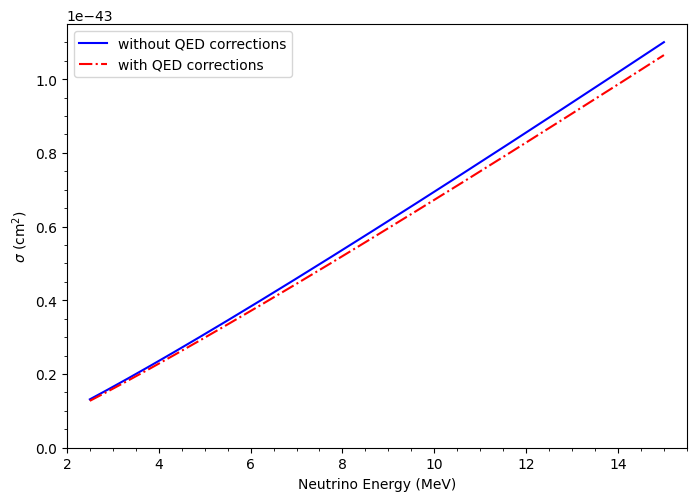

In [87]:
from matplotlib.ticker import AutoMinorLocator

E_nu_min = 2.5
E_nu_max = 15

E_nu = np.linspace(E_nu_min, E_nu_max, 200)

cross_sec = []
cross_sec_corr = []

plt.figure(figsize = (8, 5.5))
for E_nu_i in E_nu:
    cross_sec.append(cross_sec_ES_nu_e(E_nu_i))
    cross_sec_corr.append(integrated_sigma(E_nu_i))

plt.plot(E_nu, cross_sec, color = 'b', label = 'without QED corrections')
plt.plot(E_nu, cross_sec_corr, color = 'r', linestyle = '-.', label = 'with QED corrections')

plt.xlabel('Neutrino Energy (MeV)')
plt.ylabel(r'$\sigma$ (cm$^2$)')

plt.legend(loc = 'best')

plt.xlim(E_nu_min - 0.5, E_nu_max + 0.5)
plt.ylim(0,)

ax = plt.gca() 
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator()) 

plt.show()

## QED Functions Check
Use this functions with only one value for neutrino energy!

In [259]:
def f_minus(E_nu):
    
    pi = np.pi
    G_F = 1.16639 * 10 **(-2)               # Fermi Constant MeV^(-2)
    h_bar = (4.135668 * 10**(-21))/(2*pi)   # Plank bar constant in MeV.s
    m_e = 0.5109989461                      # electron mass energy in MeV/c^2 
    alpha = 1/137                           # Fine structure constant
    sin_theta_w = 0.23116                   # sin^2(Weinberg angle)
    
    E_nu = np.asarray(E_nu, dtype=float)     # Neutrino Energy
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu) #Electron max. kinetic energy
    Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0] #Electron min. kinetic energy
    T = np.linspace(Tmin, Tmax, 200)
    
    E_e = T + m_e                             # Total electron energy
    z = T / (E_nu + 1e-300)
    p_e = np.sqrt(E_e**2 - m_e**2)            # electron 3-momentum modulo
    beta = p_e / (E_e)
    
    # f-
    epsilon = 1e-100  #Logaritmic regularizer
    
    term1_minus = ((E_e/p_e)*np.log((E_e + p_e)/m_e) - 1)*(2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon)) - np.log(np.maximum(1 - z, epsilon)) - 0.5*np.log(np.maximum(z, epsilon)) - (5/12))
    term2_minus = 0.5*(spence(1 - z) - spence(1 - beta)) - 0.5 * (np.log(np.maximum(1 - z, epsilon)))**(2) - (11/12 + z/2) * np.log(np.maximum(1 - z, epsilon))
    term3_minus = z * (np.log(np.maximum(z, epsilon)) + 0.5*np.log(2*E_nu/m_e)) - (31/18 + (1/12)*np.log(np.maximum(z, epsilon)))*beta - (11/12)*z + (z**2)/24
    
    f_minus = term1_minus + term2_minus + term3_minus
    
    return {'T': T, 'z': z, 'f_minus': f_minus}
    
    
def f_plus(E_nu):
    
    pi = np.pi
    G_F = 1.16639 * 10 **(-2)               # Fermi Constant MeV^(-2)
    h_bar = (4.135668 * 10**(-21))/(2*pi)   # Plank bar constant in MeV.s
    m_e = 0.5109989461                      # electron mass energy in MeV/c^2 
    alpha = 1/137                           # Fine structure constant
    sin_theta_w = 0.23116                   # sin^2(Weinberg angle)
    
    E_nu = np.asarray(E_nu, dtype=float)
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu)
    Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0]
    T = np.linspace(Tmin, Tmax, 200)
    
    E_e = T + m_e 
    z = T / (E_nu + 1e-300)
    p_e = np.sqrt(E_e**2 - m_e**2)
    beta = p_e / (E_e)

    # (1-z)^2 * f+
    epsilon = 1e-100  #Logaritmic regularizer
    term1_plus = ((E_e/p_e)*np.log((E_e + p_e)/m_e) - 1)*(((1 - z)**2) * (2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon)) - np.log(np.maximum(1 - z, epsilon)) - 0.5*np.log(np.maximum(z, epsilon)) - 2/3) - 0.5*((z**2)*np.log(np.maximum(z, epsilon)) + 1 - z))
    term2_plus = -(0.5*(1 - z)**2)*((np.log(np.maximum(1 - z, epsilon)))**2 + beta * (spence(z) - np.log(np.maximum(z, epsilon))*np.log(np.maximum(1 - z, epsilon))))
    term3_plus = np.log(np.maximum(1 - z, epsilon))*(0.5*(z**2) * np.log(np.maximum(z, epsilon)) + ((1 - z)/3) * (2*z - 0.5))
    term4_plus = -0.5*(z**2)*spence(z) - (z*(1 - 2*z)/3) * np.log(np.maximum(z, epsilon)) - z*(1-z)/6
    term5_plus = -(beta/12) * (np.log(np.maximum(z, epsilon)) + (1 - z)*((115 - 109*z)/6))
    
    f_plus_prod = term1_plus + term2_plus + term3_plus + term4_plus + term5_plus
    f_plus = f_plus_prod / ((1-z)**2)
    
    return {'z': z, 'f_plus': f_plus}
    

def f_pm(E_nu):
    
    pi = np.pi
    G_F = 1.16639 * 10 **(-2)               # Fermi Constant MeV^(-2)
    h_bar = (4.135668 * 10**(-21))/(2*pi)   # Plank bar constant in MeV.s
    m_e = 0.5109989461                      # electron mass energy in MeV/c^2 
    alpha = 1/137                           # Fine structure constant
    sin_theta_w = 0.23116                   # sin^2(Weinberg angle)
    
    E_nu = np.asarray(E_nu, dtype=float)
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu)
    Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0]
    T = np.linspace(Tmin, Tmax, 200)
    
    E_e = T + m_e 
    z = T / (E_nu + 1e-300)
    p_e = np.sqrt(E_e**2 - m_e**2)
    beta = p_e / (E_e)
    
    epsilon = 1e-100  #Logaritmic regularizer
    f_pm = ((E_e/p_e)*np.log((E_e + p_e) / m_e) - 1) * 2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon))
    return {'z': z, 'f_pm': f_pm}

In [260]:
E_nu = 0.01

z_minus_val = f_minus(E_nu)['z']
f_minus_val = f_minus(E_nu)['f_minus']
T_minus_val = f_minus(E_nu)['T']

z_plus_val = f_plus(E_nu)['z']
f_plus_val = f_plus(E_nu)['f_plus']

z_pm_val = f_pm(E_nu)['z']
f_pm_val = f_pm(E_nu)['f_pm']

In [264]:
f_pm_val

array([-0.70996883, -0.70753919, -0.70510954, -0.70267988, -0.7002502 ,
       -0.69782051, -0.69539081, -0.6929611 , -0.69053138, -0.68810165,
       -0.6856719 , -0.68324215, -0.68081238, -0.6783826 , -0.67595281,
       -0.673523  , -0.67109319, -0.66866336, -0.66623353, -0.66380368,
       -0.66137382, -0.65894395, -0.65651406, -0.65408417, -0.65165426,
       -0.64922434, -0.64679441, -0.64436447, -0.64193452, -0.63950455,
       -0.63707458, -0.63464459, -0.63221459, -0.62978458, -0.62735456,
       -0.62492453, -0.62249448, -0.62006442, -0.61763436, -0.61520428,
       -0.61277419, -0.61034408, -0.60791397, -0.60548384, -0.60305371,
       -0.60062356, -0.5981934 , -0.59576322, -0.59333304, -0.59090284,
       -0.58847264, -0.58604242, -0.58361219, -0.58118195, -0.5787517 ,
       -0.57632143, -0.57389116, -0.57146087, -0.56903057, -0.56660026,
       -0.56416994, -0.5617396 , -0.55930926, -0.5568789 , -0.55444853,
       -0.55201815, -0.54958776, -0.54715736, -0.54472694, -0.54

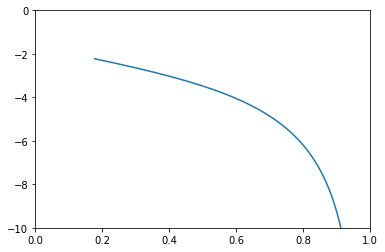

In [219]:
plt.plot(z_minus_val, f_minus_val)
plt.xlim(0, 1)
plt.ylim(-10, 0)
plt.show()

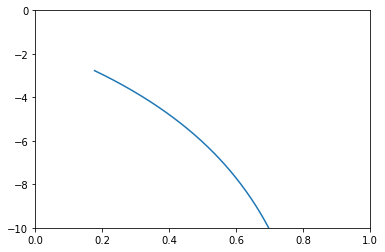

In [220]:
plt.plot(z_plus_val, f_plus_val)
plt.xlim(0, 1)
plt.ylim(-10, 0)
plt.show()

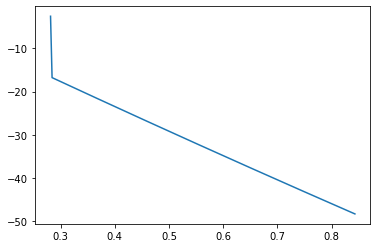

In [178]:
plt.plot(z_pm_val, f_pm_val)
#plt.xlim(0, 1)
#plt.ylim(-1, 0)
plt.show()